In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R125_bmimPF6_PR import configuration
data = pd.read_csv('R125IL3.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa['bmimPF6', 'R125'].fix(0.286364)
m.fs.properties.PR_kappa['R125', 'bmimPF6'].fix(-0.00356)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].unfix()

R125_x = np.zeros((len(data)))
P = np.zeros((len(data)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"] == m.fs.liq)

for i in range(len(data)):
    m.fs.liq = data["x_bmimPF6"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data["x_R125"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(float(1-(data["x_R125"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
    
    print("x =", data["x_bmimPF6"].iloc[i])
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

x = 0.987
x = 0.966
x = 0.925
x = 0.874
x = 0.815
x = 0.745
x = 0.658
x = 0.538
x = 0.977
x = 0.95
x = 0.92
x = 0.889
x = 0.857
x = 0.82
x = 0.739
x = 0.637
x = 0.987
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
x = 0.972
x = 0.958
x = 0.943
x = 0.928
x = 0.913
x = 0.88
x = 0.846
x = 0.993
x = 0.984
x = 0.975
x = 0.967
x = 0.957
x = 0.947
x = 0.93
x = 0.912


In [4]:
# print(P)
# print(data["pressure"])
# print(R125_x)
# print(data["x_R125"])

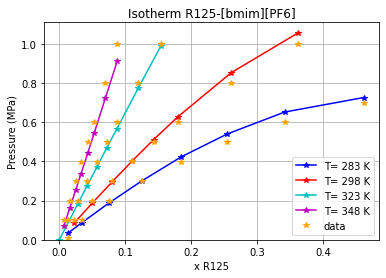

In [5]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

    
plt.plot(R125_x[0:8],P1[0:8],"b*-",label="T= 283 K")  
plt.plot(R125_x[8:16],P1[8:16],"r*-",label="T= 298 K") 
plt.plot(R125_x[16:24],P1[16:24],"c*-",label="T= 323 K") 
plt.plot(R125_x[24:],P1[24:],"m*-",label="T= 348 K")
plt.plot(data["x_R125"],data["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R125-[bmim][PF6]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R125')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty :  61.401 : False : (None, None)
    Pressure Change : -86296. : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000      0.10965       0.89035  
    mole_frac_comp bmimPF6    0.81200   1.0000e-08       0.91200  
    mole_frac_comp R125       0.18800       1.0000      0.088000  
    temperature                348.20       348.20        348.20  
    pressure               9.9960e+05   9.1330e+05    9.1330e+05  


In [7]:
# print(P1)